In [1]:
import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')

# Activity: Bootstrapping Confidence Intervals

The cell below will load in a dataset from Inside Airbnb (http://insideairbnb.com/get-the-data.html) that has details of over 2000 Airbnb listings in Asheville, NC through February 17, 2021. It includes information about the name of the property, the zip code it's in, price, and many other fields.

Today, we'll be investigating how we might be able to estimate the average price for a night at an Airbnb in Asheville, NC. There were a small number of listings (six in total) with prices over 1000 dollars which were removed from the dataset.

In [2]:
asheville = Table.read_table('data/asheville-airbnb.csv').where('price', are.below(1000))
asheville.show(5)

id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
108061,Walk to stores/parks/downtown. Fenced yard/Pets OK,320564,Lisa,28801,35.6067,-82.5556,Entire home/apt,82,30,89,11/30/2019,0.78,2,242
155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.5786,-82.5958,Entire home/apt,90,1,289,2/13/2021,2.48,7,310
156805,"Private Room ""Ader"" at BPS Hostel",746673,BonPaul,28806,35.5786,-82.5958,Private room,66,1,67,1/1/2020,0.58,7,16
156926,"Mixed Dorm ""Top Bunk #1"" at BPS Hostel",746673,BonPaul,28806,35.5786,-82.5958,Shared room,31,1,282,12/31/2020,2.45,7,281
160594,Historic Grove Park,769252,Elizabeth,28801,35.6144,-82.5413,Private room,125,30,58,10/19/2015,0.5,1,0


## Important Note:
Throughout this activity, we are going to practice our bootstrapping technique to construct a confidence interval from a single sample from the population. **Remember:** We use the bootstrap technique when we don't have access to a population, only a sample from that population. That means for this activity, **pretend** that you don't have access to the full population unless specifically asked to use it.

## Draw a Sample

Remember, our goal is to estimate the average nightly price of all Airbnb's in Asheville, NC. As discussed in the lessons, the best way to make such an estimate is to construct a confidence interval. As we've seen, larger sample sizes produce more narrow confidence intervals, meaning we have a more precise estimate of our value. However, larger samples are more expensive to take in real life (you have to spend either more time or more money to get more data in your sample). There's an inherent trade off between cost and accuracy, and when solving your own problems you have to decide how much the additional accuracy is worth to you! In a future lesson you'll learn a method for determining what size sample you should take in order to achieve a certain level of accuracy, but for now choose a sample size between 50 and 200 to use and assign it to the variable `sample_size` in the code cell below.

Then, create a sample from the `asheville` table of size `sample_size` and assign that Table to `airbnb_sample`.

In [62]:
sample_size = 250
airbnb_sample = asheville.sample(sample_size)

# Show the top 5 to see a little about your sample
airbnb_sample.show(5)

id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
34744862,Explore Asheville! Minutes to Downtown & RAD!,38005428,Emily,28715,35.5452,-82.671,Entire home/apt,114,2,70,1/24/2021,3.37,1,39
47183867,City and Mountain Views await you in this Luxury Downtow ...,167186184,Towns,28801,35.5892,-82.5521,Entire home/apt,209,1,1,1/22/2021,1,73,339
11938223,Cabin by the pond,18089084,Patricia,28803,35.547,-82.4931,Entire home/apt,115,2,47,12/22/2020,0.79,2,354
15647883,West Nest on Haywood Road,98245203,Mike,28806,35.5785,-82.5798,Entire home/apt,99,1,267,2/14/2021,5.11,1,135
20174635,Our serene cabin in the woods,138795160,Leslie,28805,35.6334,-82.4671,Entire home/apt,114,2,90,2/14/2021,2.11,1,169


# Bootstrapping the Sample

Since this is the only sample we have to use, write a function called `one_bootstrap_mean` that takes in no arguments and returns the mean value of the `price` column of a single resample of `airbnb_sample`. **Remember:** When resampling (taking a bootstrap) from a sample, you should draw the same number of elements that are contained in the sample (`sample_size`) and you should draw **with replacement**!

In [63]:
def one_bootstrap_mean():
    return np.mean(airbnb_sample.sample(sample_size, with_replacement=True).column('price'))

one_bootstrap_mean()

147.124

Now, create an array named `bootstrap_means` which contains 1000 bootstrap means of your `airbnb_sample` Table. You should follow our typical format of first constructing an empty array and then writing a `for` loop that computes the bootstrap mean (use your function from above) and appends each mean to the `bootstrap_means` array.

In [64]:
bootstrap_means = make_array()

for i in np.arange(1000):
    new_mean = one_bootstrap_mean()
    bootstrap_means = np.append(bootstrap_means, new_mean)

# Shows ONLY the first 10 bootstrap means
bootstrap_means[0:10]

array([155.916, 149.604, 157.912, 149.784, 155.732, 142.108, 155.768,
       144.072, 147.696, 141.38 ])

Create a histogram of these bootstrap means. Theory predicts that you should expect to see a normal distribution of the bootstrap means. Do you?

**Hint:** Remember, you can quickly create a histogram from an array by constructing an empty Table using `Table()` and then appending the array as a column to the table by using `.with_column( ... )` and then calling `.hist( ... )`. Be sure to provide all the needed arguments to these methods. 

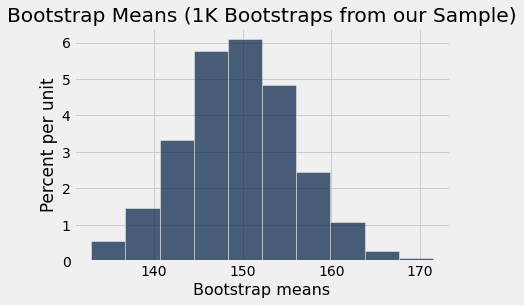

In [65]:
Table().with_column('Bootstrap means', bootstrap_means).hist()
plots.title('Bootstrap Means (1K Bootstraps from our Sample)');

In [66]:
min(bootstrap_means), max(bootstrap_means)

(132.888, 171.456)

## Constructing the Confidence Interval

To construct a 95% Confidence Interval you'll need to determine which two values in the bootstrapped distribution contain 95% of the data between them.

Use the `percentile` function to determine the left and right endpoints of a 95% Confidence Interval for the mean price. Assign these values to `left` and `right` respectively.

In [67]:
left = percentile(2.5, bootstrap_means)
right = percentile(97.5, bootstrap_means)

print("95% CI: (", left, ",", right,")")

95% CI: ( 137.352 , 162.044 )


The code below will overlay a yellow line across the base of the distribution of bootstrapped means to visually show the values in the distribution that are within the interval.

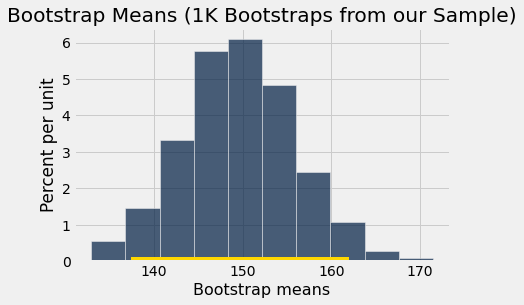

In [68]:
Table().with_column('Bootstrap means', bootstrap_means).hist()
plots.plot([left,right], [0,0], color="gold", lw=8, zorder=1);
plots.title('Bootstrap Means (1K Bootstraps from our Sample)');

## How did you do?

The goal of constructing this 95% Confidence Interval was to estimate the true average price for a night in an Airbnb in Asheville, NC. Unless we had the full dataset there'd be no way to know this actual value. In this case, we **do** have the full dataset, so we can see if our sample and bootstrapping technique resulted in an interval that contains the true population average. We should expect this process to construct an interval that contains the true mean 95% of the time, so if your interval doesn't contain the mean that doesn't necessarily mean you did this wrong! Let's see how you did.

First, let's look at the distribution of ALL prices:

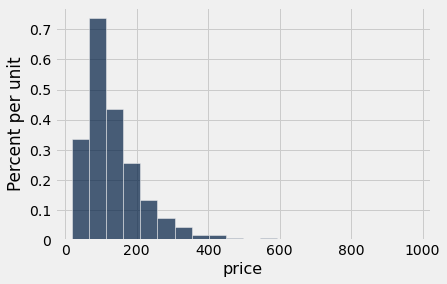

In [58]:
asheville.hist('price', bins = 20)

Next, let's look at what the average of the price column is for the `asheville` table.

In [59]:
population_mean = np.mean(asheville.column('price'))
population_mean

142.2799107142857

Is the population mean in between `left` and `right`, or put another way, did your Confidence Interval contain the true mean?

In [60]:
left < population_mean < right

True

The code below will recreate this entire process 50 times and draw all 50 confidence intervals as horizontal yellow lines. Notice how variations in the original sample that was drawn, as well as randomness in the resampling process, create variations in the Confidence Intervals. In real life, you're usually only able to construct 1 of these from your single sample you were able to obtain. You'd never know the details of how other samples and other resamples might have impacted how it *could* have gone differently. Do any of these Confidence Intervals fail to capture the true average that we were trying to predict? The true average price is drawn in as a vertical red line. If any of your yellow bars don't contain the red line, that means if you had constructed that as your confidence interval it would have NOT been a good estimate for the mean price. Because we constructed a 95% confidence interval, we'd expect that to happen about 5% of the time, or 1 out of every 20 Confidence Intervals.

**Caution:** This next cell might take a little while to run!

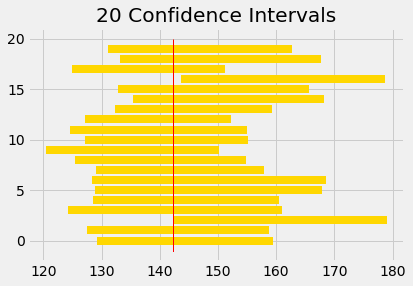

In [69]:
for i in np.arange(20):
    airbnb_sample = asheville.sample(250)
    
    bootstrap_means = make_array()
    for j in np.arange(1000):
        new_mean = one_bootstrap_mean()
        bootstrap_means = np.append(bootstrap_means, new_mean)
        left = percentile(2.5, bootstrap_means)
        right = percentile(97.5, bootstrap_means)
        plots.plot([left,right], [i,i], color="gold", lw=8, zorder=1);
    plots.plot([population_mean,population_mean], [-1,i+1], color="red", lw=1, zorder=1);
    plots.title('20 Confidence Intervals');